## Estimating the coefficient of a regression model via scikit-learn

In [2]:
'''
loading the dataset
'''
from data import load_data
import numpy as np
from sklearn.preprocessing import StandardScaler

df = load_data()
X = df[['RM']].values
y = df['MEDV'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [4]:
'''
train the Linear Regressor
'''
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


In [22]:
import os
import matplotlib.pyplot as plt

def lin_regplot(X, y, model, name=''):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    plt.xlabel('Average number of rooms [RM] (standardized)')
    plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
    plt.show()
    
#     if not os.path.exists(os.path.join(os.getcwd(), 'figures')):
#         os.mkdir('figures')
#     plt.savefig('./figures/%s.png' % (name), dpi=100)
    plt.gcf().clear()

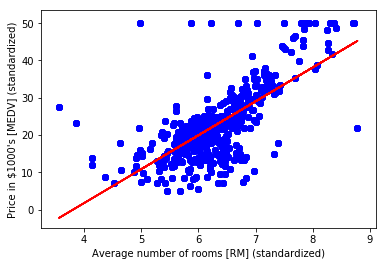

In [23]:
'''
plot a graph to compare with the results of our LinearRegression class
'''
lin_regplot(X, y, slr, 'plotting-sklearn-linear-reg')

## Fitting a robust regression model using RANSAC
__RANdom SAmple Consensus (RANSAC)__ algorithm, fits a regression model to a subset of the data, the so-called _inliers_, thus eliminating the impact of _outliers_ on the prediction model.

In [26]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(X, y)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ransac.py:261: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x7f49d16686e0>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

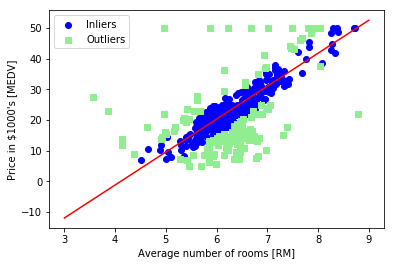

In [34]:
'''
plot the inliers and outliers obtained from RANSAC
'''
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('./figures/ransac-plot.png', dpi=120)
plt.gcf().clear()

In [35]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## Evaluating the performance of linear regression models
We will now use all variables in the dataset and train a multiple regression model

In [37]:
'''
load data and train regressor
'''
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

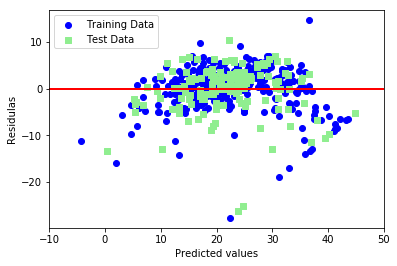

In [40]:
'''
Time to plot
------------

Since our model uses multiple explanatory variables, we can't visualize the linear
regression line in a two-dimensional plot, but we can plot the residuals versus the
predicted values to diagnose our regression model.
'''

plt.scatter(y_train_pred, y_train_pred - y_train,
           c='blue', marker='o', label='Training Data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='lightgreen', marker='s', label='Test Data')
plt.xlabel('Predicted values')
plt.ylabel('Residulas')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()
# plt.savefig('./figures/preds-vs-residuals.png', dpi=120)
plt.gcf().clear()

## Training a linear regression into a curve - polynomial regression
We will now discuss how to use the PolynomialFeatures transformer class from scikit-learn to add a quadratic term ( d = 2 ) to a simple regression problem with one explanatory variable, and compare the polynomial to the linear fit.

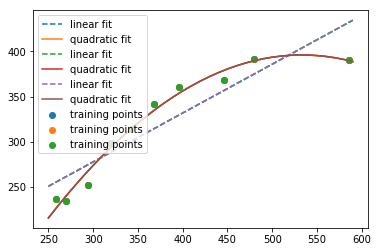

In [45]:
'''
testing polynomial regression
on random dummy data.
'''

# 1. Add a second degree polynomial term
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0,
              586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# 2. Fit a simple linear regression model for compqarison
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 3. Fit a multiple regression model on the transformed features for
#    polynomial regression:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# Plot the results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit,
        label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit,
        label='quadratic fit')
plt.legend(loc='upper left')
# plt.savefig('./figures/linear-vs-quad.png', dpi=120)
plt.show()
plt.gcf().clear()

In [ ]:
'''
Finding MSE and R^2 score.
'''
from sklearn.metrics import 
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))